# K-Fold CV for Boosting Methods Using SKLearn 

In [1]:
#Importing required libraries
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import wfdb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from numpy import mean
from numpy import absolute
from numpy import sqrt
import pandas as pd
import random

In [2]:
import xgboost as xgb
from sklearn import metrics
from lightgbm import LGBMClassifier

import lightgbm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 70 #display 70 dpi in Jupyter Notebook, may consider100 dpi 
plt.rcParams['savefig.dpi'] = 300 #define 300 dpi for saving figures

import seaborn as sns
## here are some settings 
sns.set_style('whitegrid')
sns.set(rc={"figure.dpi":70, 'savefig.dpi':300}) #defining dpi setting
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats

### To load sklearn dataset
sklearn.datasets.load_breast_cancer(*, return_X_y=False, as_frame=False)[source]¶

Load and return the breast cancer wisconsin dataset (classification).

In [4]:
#data = load_breast_cancer(as_frame = True); 
#df = data.frame; 
#print(df.shape)
# In this block use the code we looked at on 6/30 as a reference to save our rr-intervals as a .
rlist = []
records = 'mit-bih-raw\RECORDS' # Replace the _______ with the name of the records file in your MIT-BIH data folder
with open(records) as rfile: #Then we open the file 
                             #The 'with' command only opens the file while we are in it. Automatically closes the file when we're not
    for record in rfile:  # Then we iterate through the lines in the file
        record = record[0:len(record)-1] # Remove any erronious new line characters at the end ('\n')
        rlist.append(record) # Then build an array with it
        

###### Step 1: Initialize all Arrays
             # Below, replace all of the ___ with the command that declares an array/list
             # hint: https://stackoverflow.com/questions/1514553/how-to-declare-an-array-in-python
samples = [] # will house the samples of all subjects
good_list = [] # will list the names of the subjects we successfully extracted
bad_list = [] # will house the names of the subjects we failed to extract
qrs = [] # will house the indices of R-Peaks for all subjects
atr_label = [] # will house the labels for each rhythm annotation for all subjects
atr_locs = [] # will house the locations corresponding to the rhythm annotation labels


###### Step 2: Extract Information
for x in tqdm(rlist): #this will iterate through te records that we found above
  
    try: # A try statement will run the except statement if for some reason the try commands fail
         # In this case I use the try statement because one of the subjects has no signal data causing failure
         # I then use bad_list and good_list so that all of the indices in rlist match with the arrays we initialized in Step 1, above
        ######################################################
            # Below find the wfdb function that will return the information that is described below 
        # Then replace _____ with the correct function call
        samp = wfdb.rdsamp('mit-bih-raw/'+x) # wfdb._____(file_location) will read the signal & header data and return a 2 value array
            # samp[0] - the signal data is the raw reading from the ecg. Each value is a sample taken.
            # samp[1] - the header data includes things about the signal data such as:
              # samples per section, denoted 'fs'
              # number of signals, denoted 'n_sig'
            
        ######################################################
        samples.append(samp) #add it to our array for all subject
            #What is our file extension that has the annotation we want? Find it here and replace _____ with it 
            #hint: READ THE VARIABLE NAMES!!!!
        qrs_tmp = wfdb.rdann('mit-bih-raw/'+x, extension='qrs') #extract the QRS Info
        qrs_locs = np.array(qrs_tmp.sample, dtype='int') #Get just the loccation of R-Peaks from the QRS Info
        qrs.append(qrs_locs) # Add to our array for all subjects
        
            #Do the same thing here
        atr = wfdb.rdann('mit-bih-raw/'+x,extension='atr') #extract the atr info which stores the rhythm type(s) over the whole signal
        atr_label.append(atr.aux_note) # aux_note stores the type of rhythm - main two are '(N' for normal and '(AFIB' for AFIB
        atr_locs.append(np.append(atr.sample, len(samp[0]))) #I add the length of the whole sample to the end for better visualization later
        
        good_list.append(x) # when all extraction is successful append the record name to good_list
    except Exception as exep:
        print(exep) # Alert the user of an exception
        bad_list.append(x) # add to the bad list

        

  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

sampto must be greater than sampfrom
sampto must be greater than sampfrom


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.57it/s]


In [5]:
features_df_list = []
for subject in good_list:
    data = pd.read_csv(f'subject-features-dataframes/subject{subject}.csv')
    data = data.assign(Subject = subject)
    #print(data)
    features_df_list.append(data)
#features_maindf = pd.concat(features_df_list, ignore_index = True)

In [6]:
#df.head(5)
# df.info()
# df.describe()
#features_df_list[0]
counter = 0
testing_arr = []
training_arr = []
for subject in features_df_list:
    if counter != 22:
        training_arr.append(subject)
    else:
        testing_arr.append(subject)
    counter += 1
    
print(len(training_arr))

22


In [7]:
features_maindf = pd.concat(features_df_list, ignore_index = True)
print(features_maindf.columns)

Index(['Unnamed: 0', 'StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS',
       'LtoR', 'LtoL', 'STD', 'CoefVar', 'Range', 'Volatility', 'ShEn',
       'AppEn', 'SampEn', 'Rhythm', 'Subject'],
      dtype='object')


C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618356	valid_0's binary_logloss: 0.571408
[2]	training's binary_logloss: 0.55755	valid_0's binary_logloss: 0.521635
[3]	training's binary_logloss: 0.505937	valid_0's binary_logloss: 0.479841
[4]	training's binary_logloss: 0.461077	valid_0's binary_logloss: 0.444658
[5]	training's binary_logloss: 0.422435	valid_0's binary_logloss: 0.413974
[6]	training's binary_logloss: 0.38893	valid_0's binary_logloss: 0.388499
[7]	training's binary_logloss: 0.359628	valid_0's binary_logloss: 0.365992
[8]	training's binary_logloss: 0.333592	valid_0's binary_logloss: 0.347248
[9]	training's binary_logloss: 0.310288	valid_0's binary_logloss: 0.331451
[10]	training's binary_logloss: 0.289955	valid_0's binary_logloss: 0.316704
[11]	training's binary_logloss: 0.271785	valid_0's binary_logloss: 0.30466
[12]	training's binary_logloss: 0.255501	valid_0's binary_logloss: 0.293693
[13]	training's binary_logloss: 0.240837	valid_0's binary_logloss: 0.283784
[14]	training's binary_l

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618356	valid_0's binary_logloss: 0.571408
[2]	training's binary_logloss: 0.55755	valid_0's binary_logloss: 0.521635
[3]	training's binary_logloss: 0.505937	valid_0's binary_logloss: 0.479841
[4]	training's binary_logloss: 0.461077	valid_0's binary_logloss: 0.444658
[5]	training's binary_logloss: 0.422435	valid_0's binary_logloss: 0.413974
[6]	training's binary_logloss: 0.38893	valid_0's binary_logloss: 0.388499
[7]	training's binary_logloss: 0.359628	valid_0's binary_logloss: 0.365992
[8]	training's binary_logloss: 0.333592	valid_0's binary_logloss: 0.347248
[9]	training's binary_logloss: 0.310288	valid_0's binary_logloss: 0.331451
[10]	training's binary_logloss: 0.289955	valid_0's binary_logloss: 0.316704
[11]	training's binary_logloss: 0.271785	valid_0's binary_logloss: 0.30466
[12]	training's binary_logloss: 0.255501	valid_0's binary_logloss: 0.293693
[13]	training's binary_logloss: 0.240837	valid_0's binary_logloss: 0.283784
[14]	training's binary_l

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618031	valid_0's binary_logloss: 0.587241
[2]	training's binary_logloss: 0.557826	valid_0's binary_logloss: 0.529984
[3]	training's binary_logloss: 0.506602	valid_0's binary_logloss: 0.481112
[4]	training's binary_logloss: 0.462222	valid_0's binary_logloss: 0.439001
[5]	training's binary_logloss: 0.423927	valid_0's binary_logloss: 0.403011
[6]	training's binary_logloss: 0.390808	valid_0's binary_logloss: 0.372501
[7]	training's binary_logloss: 0.361402	valid_0's binary_logloss: 0.344989
[8]	training's binary_logloss: 0.335528	valid_0's binary_logloss: 0.321032
[9]	training's binary_logloss: 0.312662	valid_0's binary_logloss: 0.299857
[10]	training's binary_logloss: 0.292288	valid_0's binary_logloss: 0.281156
[11]	training's binary_logloss: 0.274419	valid_0's binary_logloss: 0.264642
[12]	training's binary_logloss: 0.258274	valid_0's binary_logloss: 0.249967
[13]	training's binary_logloss: 0.243762	valid_0's binary_logloss: 0.237395
[14]	training's binar

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618031	valid_0's binary_logloss: 0.587241
[2]	training's binary_logloss: 0.557826	valid_0's binary_logloss: 0.529984
[3]	training's binary_logloss: 0.506602	valid_0's binary_logloss: 0.481112
[4]	training's binary_logloss: 0.462222	valid_0's binary_logloss: 0.439001
[5]	training's binary_logloss: 0.423927	valid_0's binary_logloss: 0.403011
[6]	training's binary_logloss: 0.390808	valid_0's binary_logloss: 0.372501
[7]	training's binary_logloss: 0.361402	valid_0's binary_logloss: 0.344989
[8]	training's binary_logloss: 0.335528	valid_0's binary_logloss: 0.321032
[9]	training's binary_logloss: 0.312662	valid_0's binary_logloss: 0.299857
[10]	training's binary_logloss: 0.292288	valid_0's binary_logloss: 0.281156
[11]	training's binary_logloss: 0.274419	valid_0's binary_logloss: 0.264642
[12]	training's binary_logloss: 0.258274	valid_0's binary_logloss: 0.249967
[13]	training's binary_logloss: 0.243762	valid_0's binary_logloss: 0.237395
[14]	training's binar

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618971	valid_0's binary_logloss: 0.555954
[2]	training's binary_logloss: 0.558959	valid_0's binary_logloss: 0.494263
[3]	training's binary_logloss: 0.507991	valid_0's binary_logloss: 0.440917
[4]	training's binary_logloss: 0.464155	valid_0's binary_logloss: 0.395268
[5]	training's binary_logloss: 0.425893	valid_0's binary_logloss: 0.355017
[6]	training's binary_logloss: 0.392805	valid_0's binary_logloss: 0.319867
[7]	training's binary_logloss: 0.363692	valid_0's binary_logloss: 0.288908
[8]	training's binary_logloss: 0.338193	valid_0's binary_logloss: 0.261883
[9]	training's binary_logloss: 0.315528	valid_0's binary_logloss: 0.237569
[10]	training's binary_logloss: 0.295324	valid_0's binary_logloss: 0.216125
[11]	training's binary_logloss: 0.277517	valid_0's binary_logloss: 0.196706
[12]	training's binary_logloss: 0.26127	valid_0's binary_logloss: 0.179225
[13]	training's binary_logloss: 0.247062	valid_0's binary_logloss: 0.163591
[14]	training's binary

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618971	valid_0's binary_logloss: 0.555954
[2]	training's binary_logloss: 0.558959	valid_0's binary_logloss: 0.494263
[3]	training's binary_logloss: 0.507991	valid_0's binary_logloss: 0.440917
[4]	training's binary_logloss: 0.464155	valid_0's binary_logloss: 0.395268
[5]	training's binary_logloss: 0.425893	valid_0's binary_logloss: 0.355017
[6]	training's binary_logloss: 0.392805	valid_0's binary_logloss: 0.319867
[7]	training's binary_logloss: 0.363692	valid_0's binary_logloss: 0.288908
[8]	training's binary_logloss: 0.338193	valid_0's binary_logloss: 0.261883
[9]	training's binary_logloss: 0.315528	valid_0's binary_logloss: 0.237569
[10]	training's binary_logloss: 0.295324	valid_0's binary_logloss: 0.216125
[11]	training's binary_logloss: 0.277517	valid_0's binary_logloss: 0.196706
[12]	training's binary_logloss: 0.26127	valid_0's binary_logloss: 0.179225
[13]	training's binary_logloss: 0.247062	valid_0's binary_logloss: 0.163591
[14]	training's binary

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.617806	valid_0's binary_logloss: 0.582015
[2]	training's binary_logloss: 0.55692	valid_0's binary_logloss: 0.538577
[3]	training's binary_logloss: 0.505198	valid_0's binary_logloss: 0.500806
[4]	training's binary_logloss: 0.461029	valid_0's binary_logloss: 0.468758
[5]	training's binary_logloss: 0.422621	valid_0's binary_logloss: 0.44201
[6]	training's binary_logloss: 0.389259	valid_0's binary_logloss: 0.418793
[7]	training's binary_logloss: 0.359896	valid_0's binary_logloss: 0.39805
[8]	training's binary_logloss: 0.334028	valid_0's binary_logloss: 0.379569
[9]	training's binary_logloss: 0.31119	valid_0's binary_logloss: 0.363359
[10]	training's binary_logloss: 0.290954	valid_0's binary_logloss: 0.347904
[11]	training's binary_logloss: 0.27288	valid_0's binary_logloss: 0.3349
[12]	training's binary_logloss: 0.256822	valid_0's binary_logloss: 0.324482
[13]	training's binary_logloss: 0.242465	valid_0's binary_logloss: 0.313196
[14]	training's binary_loglo

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.617806	valid_0's binary_logloss: 0.582015
[2]	training's binary_logloss: 0.55692	valid_0's binary_logloss: 0.538577
[3]	training's binary_logloss: 0.505198	valid_0's binary_logloss: 0.500806
[4]	training's binary_logloss: 0.461029	valid_0's binary_logloss: 0.468758
[5]	training's binary_logloss: 0.422621	valid_0's binary_logloss: 0.44201
[6]	training's binary_logloss: 0.389259	valid_0's binary_logloss: 0.418793
[7]	training's binary_logloss: 0.359896	valid_0's binary_logloss: 0.39805
[8]	training's binary_logloss: 0.334028	valid_0's binary_logloss: 0.379569
[9]	training's binary_logloss: 0.31119	valid_0's binary_logloss: 0.363359
[10]	training's binary_logloss: 0.290954	valid_0's binary_logloss: 0.347904
[11]	training's binary_logloss: 0.27288	valid_0's binary_logloss: 0.3349
[12]	training's binary_logloss: 0.256822	valid_0's binary_logloss: 0.324482
[13]	training's binary_logloss: 0.242465	valid_0's binary_logloss: 0.313196
[14]	training's binary_loglo

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.61445	valid_0's binary_logloss: 0.645708
[2]	training's binary_logloss: 0.55478	valid_0's binary_logloss: 0.572508
[3]	training's binary_logloss: 0.504202	valid_0's binary_logloss: 0.510262
[4]	training's binary_logloss: 0.460493	valid_0's binary_logloss: 0.45734
[5]	training's binary_logloss: 0.422878	valid_0's binary_logloss: 0.411441
[6]	training's binary_logloss: 0.389921	valid_0's binary_logloss: 0.371323
[7]	training's binary_logloss: 0.361302	valid_0's binary_logloss: 0.336232
[8]	training's binary_logloss: 0.335705	valid_0's binary_logloss: 0.305397
[9]	training's binary_logloss: 0.313508	valid_0's binary_logloss: 0.278328
[10]	training's binary_logloss: 0.293543	valid_0's binary_logloss: 0.25383
[11]	training's binary_logloss: 0.275866	valid_0's binary_logloss: 0.232286
[12]	training's binary_logloss: 0.259752	valid_0's binary_logloss: 0.212982
[13]	training's binary_logloss: 0.245542	valid_0's binary_logloss: 0.195566
[14]	training's binary_lo

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.61445	valid_0's binary_logloss: 0.645708
[2]	training's binary_logloss: 0.55478	valid_0's binary_logloss: 0.572508
[3]	training's binary_logloss: 0.504202	valid_0's binary_logloss: 0.510262
[4]	training's binary_logloss: 0.460493	valid_0's binary_logloss: 0.45734
[5]	training's binary_logloss: 0.422878	valid_0's binary_logloss: 0.411441
[6]	training's binary_logloss: 0.389921	valid_0's binary_logloss: 0.371323
[7]	training's binary_logloss: 0.361302	valid_0's binary_logloss: 0.336232
[8]	training's binary_logloss: 0.335705	valid_0's binary_logloss: 0.305397
[9]	training's binary_logloss: 0.313508	valid_0's binary_logloss: 0.278328
[10]	training's binary_logloss: 0.293543	valid_0's binary_logloss: 0.25383
[11]	training's binary_logloss: 0.275866	valid_0's binary_logloss: 0.232286
[12]	training's binary_logloss: 0.259752	valid_0's binary_logloss: 0.212982
[13]	training's binary_logloss: 0.245542	valid_0's binary_logloss: 0.195566
[14]	training's binary_lo

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.619273	valid_0's binary_logloss: 0.586657
[2]	training's binary_logloss: 0.558414	valid_0's binary_logloss: 0.529604
[3]	training's binary_logloss: 0.506881	valid_0's binary_logloss: 0.481345
[4]	training's binary_logloss: 0.462765	valid_0's binary_logloss: 0.439885
[5]	training's binary_logloss: 0.424584	valid_0's binary_logloss: 0.40474
[6]	training's binary_logloss: 0.391336	valid_0's binary_logloss: 0.373663
[7]	training's binary_logloss: 0.362068	valid_0's binary_logloss: 0.346935
[8]	training's binary_logloss: 0.33646	valid_0's binary_logloss: 0.323364
[9]	training's binary_logloss: 0.313695	valid_0's binary_logloss: 0.302781
[10]	training's binary_logloss: 0.293503	valid_0's binary_logloss: 0.284574
[11]	training's binary_logloss: 0.275447	valid_0's binary_logloss: 0.268775
[12]	training's binary_logloss: 0.259284	valid_0's binary_logloss: 0.259389
[13]	training's binary_logloss: 0.244673	valid_0's binary_logloss: 0.247979
[14]	training's binary_

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.619273	valid_0's binary_logloss: 0.586657
[2]	training's binary_logloss: 0.558414	valid_0's binary_logloss: 0.529604
[3]	training's binary_logloss: 0.506897	valid_0's binary_logloss: 0.481483
[4]	training's binary_logloss: 0.462777	valid_0's binary_logloss: 0.44004
[5]	training's binary_logloss: 0.424702	valid_0's binary_logloss: 0.404665
[6]	training's binary_logloss: 0.391342	valid_0's binary_logloss: 0.373748
[7]	training's binary_logloss: 0.362165	valid_0's binary_logloss: 0.347002
[8]	training's binary_logloss: 0.336533	valid_0's binary_logloss: 0.322976
[9]	training's binary_logloss: 0.313644	valid_0's binary_logloss: 0.301902
[10]	training's binary_logloss: 0.293652	valid_0's binary_logloss: 0.284969
[11]	training's binary_logloss: 0.275575	valid_0's binary_logloss: 0.269106
[12]	training's binary_logloss: 0.259482	valid_0's binary_logloss: 0.259731
[13]	training's binary_logloss: 0.244874	valid_0's binary_logloss: 0.248147
[14]	training's binary

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.611183	valid_0's binary_logloss: 0.704597
[2]	training's binary_logloss: 0.550091	valid_0's binary_logloss: 0.654718
[3]	training's binary_logloss: 0.498489	valid_0's binary_logloss: 0.612037
[4]	training's binary_logloss: 0.454267	valid_0's binary_logloss: 0.578621
[5]	training's binary_logloss: 0.415761	valid_0's binary_logloss: 0.548785
[6]	training's binary_logloss: 0.382235	valid_0's binary_logloss: 0.523573
[7]	training's binary_logloss: 0.353008	valid_0's binary_logloss: 0.501463
[8]	training's binary_logloss: 0.326816	valid_0's binary_logloss: 0.484982
[9]	training's binary_logloss: 0.303896	valid_0's binary_logloss: 0.472314
[10]	training's binary_logloss: 0.283364	valid_0's binary_logloss: 0.459396
[11]	training's binary_logloss: 0.26519	valid_0's binary_logloss: 0.450129
[12]	training's binary_logloss: 0.248967	valid_0's binary_logloss: 0.439502
[13]	training's binary_logloss: 0.234426	valid_0's binary_logloss: 0.432819
[14]	training's binary

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.611158	valid_0's binary_logloss: 0.704557
[2]	training's binary_logloss: 0.550056	valid_0's binary_logloss: 0.654679
[3]	training's binary_logloss: 0.498458	valid_0's binary_logloss: 0.611978
[4]	training's binary_logloss: 0.454251	valid_0's binary_logloss: 0.578231
[5]	training's binary_logloss: 0.415863	valid_0's binary_logloss: 0.547121
[6]	training's binary_logloss: 0.382357	valid_0's binary_logloss: 0.522196
[7]	training's binary_logloss: 0.353078	valid_0's binary_logloss: 0.500826
[8]	training's binary_logloss: 0.326855	valid_0's binary_logloss: 0.48349
[9]	training's binary_logloss: 0.303885	valid_0's binary_logloss: 0.470271
[10]	training's binary_logloss: 0.283444	valid_0's binary_logloss: 0.4589
[11]	training's binary_logloss: 0.265179	valid_0's binary_logloss: 0.447636
[12]	training's binary_logloss: 0.24878	valid_0's binary_logloss: 0.440637
[13]	training's binary_logloss: 0.234318	valid_0's binary_logloss: 0.433229
[14]	training's binary_lo

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618809	valid_0's binary_logloss: 0.552484
[2]	training's binary_logloss: 0.558743	valid_0's binary_logloss: 0.490586
[3]	training's binary_logloss: 0.507786	valid_0's binary_logloss: 0.437714
[4]	training's binary_logloss: 0.463908	valid_0's binary_logloss: 0.392085
[5]	training's binary_logloss: 0.425898	valid_0's binary_logloss: 0.35257
[6]	training's binary_logloss: 0.392658	valid_0's binary_logloss: 0.317586
[7]	training's binary_logloss: 0.36369	valid_0's binary_logloss: 0.286806
[8]	training's binary_logloss: 0.338021	valid_0's binary_logloss: 0.259678
[9]	training's binary_logloss: 0.315391	valid_0's binary_logloss: 0.235393
[10]	training's binary_logloss: 0.295452	valid_0's binary_logloss: 0.213807
[11]	training's binary_logloss: 0.277357	valid_0's binary_logloss: 0.194438
[12]	training's binary_logloss: 0.261306	valid_0's binary_logloss: 0.177348
[13]	training's binary_logloss: 0.246873	valid_0's binary_logloss: 0.161702
[14]	training's binary_

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618809	valid_0's binary_logloss: 0.552484
[2]	training's binary_logloss: 0.558743	valid_0's binary_logloss: 0.490586
[3]	training's binary_logloss: 0.507786	valid_0's binary_logloss: 0.437714
[4]	training's binary_logloss: 0.463908	valid_0's binary_logloss: 0.392085
[5]	training's binary_logloss: 0.425898	valid_0's binary_logloss: 0.35257
[6]	training's binary_logloss: 0.392658	valid_0's binary_logloss: 0.317586
[7]	training's binary_logloss: 0.36369	valid_0's binary_logloss: 0.286806
[8]	training's binary_logloss: 0.338021	valid_0's binary_logloss: 0.259678
[9]	training's binary_logloss: 0.315391	valid_0's binary_logloss: 0.235393
[10]	training's binary_logloss: 0.295452	valid_0's binary_logloss: 0.213807
[11]	training's binary_logloss: 0.277357	valid_0's binary_logloss: 0.194438
[12]	training's binary_logloss: 0.261306	valid_0's binary_logloss: 0.177348
[13]	training's binary_logloss: 0.246873	valid_0's binary_logloss: 0.161702
[14]	training's binary_

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.61331	valid_0's binary_logloss: 0.666351
[2]	training's binary_logloss: 0.553059	valid_0's binary_logloss: 0.602082
[3]	training's binary_logloss: 0.502024	valid_0's binary_logloss: 0.547852
[4]	training's binary_logloss: 0.458035	valid_0's binary_logloss: 0.502356
[5]	training's binary_logloss: 0.419923	valid_0's binary_logloss: 0.462547
[6]	training's binary_logloss: 0.386748	valid_0's binary_logloss: 0.428637
[7]	training's binary_logloss: 0.357564	valid_0's binary_logloss: 0.398481
[8]	training's binary_logloss: 0.331938	valid_0's binary_logloss: 0.372235
[9]	training's binary_logloss: 0.309253	valid_0's binary_logloss: 0.349561
[10]	training's binary_logloss: 0.289131	valid_0's binary_logloss: 0.329646
[11]	training's binary_logloss: 0.271193	valid_0's binary_logloss: 0.311826
[12]	training's binary_logloss: 0.255244	valid_0's binary_logloss: 0.29658
[13]	training's binary_logloss: 0.240787	valid_0's binary_logloss: 0.282563
[14]	training's binary_

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.61331	valid_0's binary_logloss: 0.666351
[2]	training's binary_logloss: 0.553059	valid_0's binary_logloss: 0.602082
[3]	training's binary_logloss: 0.502024	valid_0's binary_logloss: 0.547852
[4]	training's binary_logloss: 0.458035	valid_0's binary_logloss: 0.502356
[5]	training's binary_logloss: 0.419935	valid_0's binary_logloss: 0.462557
[6]	training's binary_logloss: 0.386742	valid_0's binary_logloss: 0.42869
[7]	training's binary_logloss: 0.357612	valid_0's binary_logloss: 0.398811
[8]	training's binary_logloss: 0.331943	valid_0's binary_logloss: 0.373025
[9]	training's binary_logloss: 0.309306	valid_0's binary_logloss: 0.349861
[10]	training's binary_logloss: 0.289245	valid_0's binary_logloss: 0.330096
[11]	training's binary_logloss: 0.271014	valid_0's binary_logloss: 0.311797
[12]	training's binary_logloss: 0.255015	valid_0's binary_logloss: 0.296397
[13]	training's binary_logloss: 0.240835	valid_0's binary_logloss: 0.283153
[14]	training's binary_

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618701	valid_0's binary_logloss: 0.567326
[2]	training's binary_logloss: 0.5582	valid_0's binary_logloss: 0.511764
[3]	training's binary_logloss: 0.507059	valid_0's binary_logloss: 0.463966
[4]	training's binary_logloss: 0.463082	valid_0's binary_logloss: 0.422877
[5]	training's binary_logloss: 0.424842	valid_0's binary_logloss: 0.387108
[6]	training's binary_logloss: 0.391825	valid_0's binary_logloss: 0.355763
[7]	training's binary_logloss: 0.362646	valid_0's binary_logloss: 0.327892
[8]	training's binary_logloss: 0.337198	valid_0's binary_logloss: 0.303685
[9]	training's binary_logloss: 0.314552	valid_0's binary_logloss: 0.282504
[10]	training's binary_logloss: 0.294239	valid_0's binary_logloss: 0.263543
[11]	training's binary_logloss: 0.276199	valid_0's binary_logloss: 0.246375
[12]	training's binary_logloss: 0.26017	valid_0's binary_logloss: 0.230837
[13]	training's binary_logloss: 0.245688	valid_0's binary_logloss: 0.21716
[14]	training's binary_lo

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618701	valid_0's binary_logloss: 0.567326
[2]	training's binary_logloss: 0.558192	valid_0's binary_logloss: 0.511745
[3]	training's binary_logloss: 0.507049	valid_0's binary_logloss: 0.463945
[4]	training's binary_logloss: 0.46307	valid_0's binary_logloss: 0.422857
[5]	training's binary_logloss: 0.42482	valid_0's binary_logloss: 0.387132
[6]	training's binary_logloss: 0.391788	valid_0's binary_logloss: 0.355808
[7]	training's binary_logloss: 0.362546	valid_0's binary_logloss: 0.327946
[8]	training's binary_logloss: 0.336902	valid_0's binary_logloss: 0.303864
[9]	training's binary_logloss: 0.314234	valid_0's binary_logloss: 0.282259
[10]	training's binary_logloss: 0.29404	valid_0's binary_logloss: 0.263094
[11]	training's binary_logloss: 0.275985	valid_0's binary_logloss: 0.245643
[12]	training's binary_logloss: 0.259867	valid_0's binary_logloss: 0.231012
[13]	training's binary_logloss: 0.245374	valid_0's binary_logloss: 0.21697
[14]	training's binary_lo

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.60964	valid_0's binary_logloss: 0.742147
[2]	training's binary_logloss: 0.550117	valid_0's binary_logloss: 0.656346
[3]	training's binary_logloss: 0.49939	valid_0's binary_logloss: 0.58486
[4]	training's binary_logloss: 0.455975	valid_0's binary_logloss: 0.524415
[5]	training's binary_logloss: 0.41859	valid_0's binary_logloss: 0.472895
[6]	training's binary_logloss: 0.3859	valid_0's binary_logloss: 0.428285
[7]	training's binary_logloss: 0.357401	valid_0's binary_logloss: 0.389629
[8]	training's binary_logloss: 0.332311	valid_0's binary_logloss: 0.355856
[9]	training's binary_logloss: 0.310258	valid_0's binary_logloss: 0.326169
[10]	training's binary_logloss: 0.290449	valid_0's binary_logloss: 0.299745
[11]	training's binary_logloss: 0.273023	valid_0's binary_logloss: 0.276139
[12]	training's binary_logloss: 0.257251	valid_0's binary_logloss: 0.255441
[13]	training's binary_logloss: 0.242924	valid_0's binary_logloss: 0.237008
[14]	training's binary_logl

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.60964	valid_0's binary_logloss: 0.742147
[2]	training's binary_logloss: 0.550117	valid_0's binary_logloss: 0.656346
[3]	training's binary_logloss: 0.49939	valid_0's binary_logloss: 0.58486
[4]	training's binary_logloss: 0.455975	valid_0's binary_logloss: 0.524415
[5]	training's binary_logloss: 0.41859	valid_0's binary_logloss: 0.472895
[6]	training's binary_logloss: 0.3859	valid_0's binary_logloss: 0.428285
[7]	training's binary_logloss: 0.357401	valid_0's binary_logloss: 0.389629
[8]	training's binary_logloss: 0.332311	valid_0's binary_logloss: 0.355856
[9]	training's binary_logloss: 0.310258	valid_0's binary_logloss: 0.326169
[10]	training's binary_logloss: 0.290449	valid_0's binary_logloss: 0.299745
[11]	training's binary_logloss: 0.273023	valid_0's binary_logloss: 0.276139
[12]	training's binary_logloss: 0.257251	valid_0's binary_logloss: 0.255441
[13]	training's binary_logloss: 0.242924	valid_0's binary_logloss: 0.237008
[14]	training's binary_logl

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618523	valid_0's binary_logloss: 0.554149
[2]	training's binary_logloss: 0.558437	valid_0's binary_logloss: 0.493825
[3]	training's binary_logloss: 0.507192	valid_0's binary_logloss: 0.442632
[4]	training's binary_logloss: 0.463226	valid_0's binary_logloss: 0.39824
[5]	training's binary_logloss: 0.425038	valid_0's binary_logloss: 0.359722
[6]	training's binary_logloss: 0.391729	valid_0's binary_logloss: 0.325808
[7]	training's binary_logloss: 0.362647	valid_0's binary_logloss: 0.29596
[8]	training's binary_logloss: 0.337163	valid_0's binary_logloss: 0.269642
[9]	training's binary_logloss: 0.314487	valid_0's binary_logloss: 0.24625
[10]	training's binary_logloss: 0.294465	valid_0's binary_logloss: 0.225362
[11]	training's binary_logloss: 0.276306	valid_0's binary_logloss: 0.207021
[12]	training's binary_logloss: 0.260372	valid_0's binary_logloss: 0.190315
[13]	training's binary_logloss: 0.245963	valid_0's binary_logloss: 0.175313
[14]	training's binary_l

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618523	valid_0's binary_logloss: 0.554149
[2]	training's binary_logloss: 0.558437	valid_0's binary_logloss: 0.493825
[3]	training's binary_logloss: 0.507167	valid_0's binary_logloss: 0.442652
[4]	training's binary_logloss: 0.463172	valid_0's binary_logloss: 0.398288
[5]	training's binary_logloss: 0.425181	valid_0's binary_logloss: 0.35973
[6]	training's binary_logloss: 0.391856	valid_0's binary_logloss: 0.325689
[7]	training's binary_logloss: 0.362786	valid_0's binary_logloss: 0.295877
[8]	training's binary_logloss: 0.33722	valid_0's binary_logloss: 0.269543
[9]	training's binary_logloss: 0.314576	valid_0's binary_logloss: 0.246544
[10]	training's binary_logloss: 0.29438	valid_0's binary_logloss: 0.225618
[11]	training's binary_logloss: 0.276344	valid_0's binary_logloss: 0.207185
[12]	training's binary_logloss: 0.260354	valid_0's binary_logloss: 0.190433
[13]	training's binary_logloss: 0.245992	valid_0's binary_logloss: 0.175624
[14]	training's binary_l

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.614536	valid_0's binary_logloss: 0.651825
[2]	training's binary_logloss: 0.552764	valid_0's binary_logloss: 0.614605
[3]	training's binary_logloss: 0.500443	valid_0's binary_logloss: 0.584559
[4]	training's binary_logloss: 0.455375	valid_0's binary_logloss: 0.560447
[5]	training's binary_logloss: 0.417003	valid_0's binary_logloss: 0.537938
[6]	training's binary_logloss: 0.383179	valid_0's binary_logloss: 0.522728
[7]	training's binary_logloss: 0.353568	valid_0's binary_logloss: 0.507139
[8]	training's binary_logloss: 0.327589	valid_0's binary_logloss: 0.497381
[9]	training's binary_logloss: 0.304672	valid_0's binary_logloss: 0.485659
[10]	training's binary_logloss: 0.283939	valid_0's binary_logloss: 0.47798
[11]	training's binary_logloss: 0.265664	valid_0's binary_logloss: 0.472403
[12]	training's binary_logloss: 0.249283	valid_0's binary_logloss: 0.465103
[13]	training's binary_logloss: 0.234699	valid_0's binary_logloss: 0.458651
[14]	training's binary

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.614536	valid_0's binary_logloss: 0.651825
[2]	training's binary_logloss: 0.552764	valid_0's binary_logloss: 0.614605
[3]	training's binary_logloss: 0.500443	valid_0's binary_logloss: 0.584559
[4]	training's binary_logloss: 0.455375	valid_0's binary_logloss: 0.560447
[5]	training's binary_logloss: 0.417003	valid_0's binary_logloss: 0.537938
[6]	training's binary_logloss: 0.383179	valid_0's binary_logloss: 0.522728
[7]	training's binary_logloss: 0.353568	valid_0's binary_logloss: 0.507139
[8]	training's binary_logloss: 0.327589	valid_0's binary_logloss: 0.497381
[9]	training's binary_logloss: 0.304672	valid_0's binary_logloss: 0.485659
[10]	training's binary_logloss: 0.283939	valid_0's binary_logloss: 0.47798
[11]	training's binary_logloss: 0.265664	valid_0's binary_logloss: 0.472403
[12]	training's binary_logloss: 0.249283	valid_0's binary_logloss: 0.465103
[13]	training's binary_logloss: 0.234699	valid_0's binary_logloss: 0.458651
[14]	training's binary

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.611531	valid_0's binary_logloss: 0.74872
[2]	training's binary_logloss: 0.551738	valid_0's binary_logloss: 0.67037
[3]	training's binary_logloss: 0.500831	valid_0's binary_logloss: 0.606065
[4]	training's binary_logloss: 0.457465	valid_0's binary_logloss: 0.550493
[5]	training's binary_logloss: 0.419835	valid_0's binary_logloss: 0.502406
[6]	training's binary_logloss: 0.387095	valid_0's binary_logloss: 0.462184
[7]	training's binary_logloss: 0.358576	valid_0's binary_logloss: 0.425906
[8]	training's binary_logloss: 0.333278	valid_0's binary_logloss: 0.394705
[9]	training's binary_logloss: 0.311112	valid_0's binary_logloss: 0.366784
[10]	training's binary_logloss: 0.291307	valid_0's binary_logloss: 0.342477
[11]	training's binary_logloss: 0.273645	valid_0's binary_logloss: 0.32228
[12]	training's binary_logloss: 0.257696	valid_0's binary_logloss: 0.303049
[13]	training's binary_logloss: 0.243601	valid_0's binary_logloss: 0.284696
[14]	training's binary_l

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.611531	valid_0's binary_logloss: 0.74872
[2]	training's binary_logloss: 0.551738	valid_0's binary_logloss: 0.67037
[3]	training's binary_logloss: 0.500968	valid_0's binary_logloss: 0.606065
[4]	training's binary_logloss: 0.457573	valid_0's binary_logloss: 0.550493
[5]	training's binary_logloss: 0.419861	valid_0's binary_logloss: 0.502341
[6]	training's binary_logloss: 0.387129	valid_0's binary_logloss: 0.461884
[7]	training's binary_logloss: 0.358577	valid_0's binary_logloss: 0.42571
[8]	training's binary_logloss: 0.333317	valid_0's binary_logloss: 0.395453
[9]	training's binary_logloss: 0.311111	valid_0's binary_logloss: 0.367271
[10]	training's binary_logloss: 0.291139	valid_0's binary_logloss: 0.343514
[11]	training's binary_logloss: 0.273603	valid_0's binary_logloss: 0.322918
[12]	training's binary_logloss: 0.257599	valid_0's binary_logloss: 0.301327
[13]	training's binary_logloss: 0.243279	valid_0's binary_logloss: 0.283898
[14]	training's binary_l

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.60551	valid_0's binary_logloss: 0.842989
[2]	training's binary_logloss: 0.543833	valid_0's binary_logloss: 0.833911
[3]	training's binary_logloss: 0.491807	valid_0's binary_logloss: 0.829444
[4]	training's binary_logloss: 0.44722	valid_0's binary_logloss: 0.824226
[5]	training's binary_logloss: 0.408786	valid_0's binary_logloss: 0.818321
[6]	training's binary_logloss: 0.375369	valid_0's binary_logloss: 0.8205
[7]	training's binary_logloss: 0.346106	valid_0's binary_logloss: 0.820218
[8]	training's binary_logloss: 0.320178	valid_0's binary_logloss: 0.823259
[9]	training's binary_logloss: 0.297226	valid_0's binary_logloss: 0.825573
[10]	training's binary_logloss: 0.277009	valid_0's binary_logloss: 0.829164
[11]	training's binary_logloss: 0.258902	valid_0's binary_logloss: 0.839119
[12]	training's binary_logloss: 0.242556	valid_0's binary_logloss: 0.844743
[13]	training's binary_logloss: 0.227942	valid_0's binary_logloss: 0.855529
[14]	training's binary_lo

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.60551	valid_0's binary_logloss: 0.842989
[2]	training's binary_logloss: 0.543833	valid_0's binary_logloss: 0.833911
[3]	training's binary_logloss: 0.491807	valid_0's binary_logloss: 0.829444
[4]	training's binary_logloss: 0.44722	valid_0's binary_logloss: 0.824226
[5]	training's binary_logloss: 0.408786	valid_0's binary_logloss: 0.818321
[6]	training's binary_logloss: 0.375369	valid_0's binary_logloss: 0.8205
[7]	training's binary_logloss: 0.346106	valid_0's binary_logloss: 0.820218
[8]	training's binary_logloss: 0.320178	valid_0's binary_logloss: 0.823259
[9]	training's binary_logloss: 0.297226	valid_0's binary_logloss: 0.825573
[10]	training's binary_logloss: 0.277009	valid_0's binary_logloss: 0.829164
[11]	training's binary_logloss: 0.258902	valid_0's binary_logloss: 0.839119
[12]	training's binary_logloss: 0.242556	valid_0's binary_logloss: 0.844743
[13]	training's binary_logloss: 0.227942	valid_0's binary_logloss: 0.855529
[14]	training's binary_lo

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.613166	valid_0's binary_logloss: 0.66977
[2]	training's binary_logloss: 0.553174	valid_0's binary_logloss: 0.598476
[3]	training's binary_logloss: 0.502196	valid_0's binary_logloss: 0.539332
[4]	training's binary_logloss: 0.458775	valid_0's binary_logloss: 0.488621
[5]	training's binary_logloss: 0.421057	valid_0's binary_logloss: 0.443955
[6]	training's binary_logloss: 0.388324	valid_0's binary_logloss: 0.405252
[7]	training's binary_logloss: 0.359526	valid_0's binary_logloss: 0.372577
[8]	training's binary_logloss: 0.334175	valid_0's binary_logloss: 0.343291
[9]	training's binary_logloss: 0.311703	valid_0's binary_logloss: 0.316781
[10]	training's binary_logloss: 0.291932	valid_0's binary_logloss: 0.293859
[11]	training's binary_logloss: 0.274176	valid_0's binary_logloss: 0.272703
[12]	training's binary_logloss: 0.258331	valid_0's binary_logloss: 0.253543
[13]	training's binary_logloss: 0.244162	valid_0's binary_logloss: 0.236058
[14]	training's binary

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.613166	valid_0's binary_logloss: 0.66977
[2]	training's binary_logloss: 0.553174	valid_0's binary_logloss: 0.598476
[3]	training's binary_logloss: 0.502196	valid_0's binary_logloss: 0.539332
[4]	training's binary_logloss: 0.458775	valid_0's binary_logloss: 0.488621
[5]	training's binary_logloss: 0.421057	valid_0's binary_logloss: 0.443955
[6]	training's binary_logloss: 0.388324	valid_0's binary_logloss: 0.405252
[7]	training's binary_logloss: 0.359526	valid_0's binary_logloss: 0.372577
[8]	training's binary_logloss: 0.334175	valid_0's binary_logloss: 0.343291
[9]	training's binary_logloss: 0.311703	valid_0's binary_logloss: 0.316781
[10]	training's binary_logloss: 0.291932	valid_0's binary_logloss: 0.293859
[11]	training's binary_logloss: 0.274176	valid_0's binary_logloss: 0.272703
[12]	training's binary_logloss: 0.258331	valid_0's binary_logloss: 0.253543
[13]	training's binary_logloss: 0.244162	valid_0's binary_logloss: 0.236058
[14]	training's binary

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.617748	valid_0's binary_logloss: 0.57054
[2]	training's binary_logloss: 0.557663	valid_0's binary_logloss: 0.508328
[3]	training's binary_logloss: 0.506389	valid_0's binary_logloss: 0.455256
[4]	training's binary_logloss: 0.462484	valid_0's binary_logloss: 0.409659
[5]	training's binary_logloss: 0.424635	valid_0's binary_logloss: 0.369875
[6]	training's binary_logloss: 0.391414	valid_0's binary_logloss: 0.334895
[7]	training's binary_logloss: 0.362367	valid_0's binary_logloss: 0.304375
[8]	training's binary_logloss: 0.336846	valid_0's binary_logloss: 0.277487
[9]	training's binary_logloss: 0.314401	valid_0's binary_logloss: 0.253668
[10]	training's binary_logloss: 0.294411	valid_0's binary_logloss: 0.232331
[11]	training's binary_logloss: 0.276474	valid_0's binary_logloss: 0.213671
[12]	training's binary_logloss: 0.260543	valid_0's binary_logloss: 0.196675
[13]	training's binary_logloss: 0.246069	valid_0's binary_logloss: 0.181126
[14]	training's binary

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.617748	valid_0's binary_logloss: 0.57054
[2]	training's binary_logloss: 0.557663	valid_0's binary_logloss: 0.508328
[3]	training's binary_logloss: 0.506382	valid_0's binary_logloss: 0.455331
[4]	training's binary_logloss: 0.462491	valid_0's binary_logloss: 0.409614
[5]	training's binary_logloss: 0.424677	valid_0's binary_logloss: 0.37002
[6]	training's binary_logloss: 0.391406	valid_0's binary_logloss: 0.335089
[7]	training's binary_logloss: 0.362341	valid_0's binary_logloss: 0.304637
[8]	training's binary_logloss: 0.336722	valid_0's binary_logloss: 0.277554
[9]	training's binary_logloss: 0.314286	valid_0's binary_logloss: 0.253467
[10]	training's binary_logloss: 0.294325	valid_0's binary_logloss: 0.232443
[11]	training's binary_logloss: 0.276494	valid_0's binary_logloss: 0.21363
[12]	training's binary_logloss: 0.260373	valid_0's binary_logloss: 0.196627
[13]	training's binary_logloss: 0.245906	valid_0's binary_logloss: 0.181122
[14]	training's binary_l

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.613431	valid_0's binary_logloss: 0.67455
[2]	training's binary_logloss: 0.553649	valid_0's binary_logloss: 0.598438
[3]	training's binary_logloss: 0.502975	valid_0's binary_logloss: 0.53437
[4]	training's binary_logloss: 0.459241	valid_0's binary_logloss: 0.478847
[5]	training's binary_logloss: 0.421462	valid_0's binary_logloss: 0.430853
[6]	training's binary_logloss: 0.388649	valid_0's binary_logloss: 0.389316
[7]	training's binary_logloss: 0.359978	valid_0's binary_logloss: 0.353091
[8]	training's binary_logloss: 0.334672	valid_0's binary_logloss: 0.320867
[9]	training's binary_logloss: 0.312161	valid_0's binary_logloss: 0.292821
[10]	training's binary_logloss: 0.292466	valid_0's binary_logloss: 0.268001
[11]	training's binary_logloss: 0.274448	valid_0's binary_logloss: 0.245358
[12]	training's binary_logloss: 0.258642	valid_0's binary_logloss: 0.22656
[13]	training's binary_logloss: 0.244482	valid_0's binary_logloss: 0.208665
[14]	training's binary_l

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.613432	valid_0's binary_logloss: 0.674295
[2]	training's binary_logloss: 0.553655	valid_0's binary_logloss: 0.598211
[3]	training's binary_logloss: 0.50298	valid_0's binary_logloss: 0.534158
[4]	training's binary_logloss: 0.459268	valid_0's binary_logloss: 0.478656
[5]	training's binary_logloss: 0.421489	valid_0's binary_logloss: 0.430678
[6]	training's binary_logloss: 0.388721	valid_0's binary_logloss: 0.389276
[7]	training's binary_logloss: 0.360039	valid_0's binary_logloss: 0.352908
[8]	training's binary_logloss: 0.334739	valid_0's binary_logloss: 0.320714
[9]	training's binary_logloss: 0.312248	valid_0's binary_logloss: 0.292803
[10]	training's binary_logloss: 0.292423	valid_0's binary_logloss: 0.267521
[11]	training's binary_logloss: 0.274735	valid_0's binary_logloss: 0.246485
[12]	training's binary_logloss: 0.258795	valid_0's binary_logloss: 0.226625
[13]	training's binary_logloss: 0.244229	valid_0's binary_logloss: 0.20864
[14]	training's binary_

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.61584	valid_0's binary_logloss: 0.6302
[2]	training's binary_logloss: 0.553717	valid_0's binary_logloss: 0.610311
[3]	training's binary_logloss: 0.500536	valid_0's binary_logloss: 0.590345
[4]	training's binary_logloss: 0.455055	valid_0's binary_logloss: 0.575568
[5]	training's binary_logloss: 0.415733	valid_0's binary_logloss: 0.563236
[6]	training's binary_logloss: 0.381627	valid_0's binary_logloss: 0.555168
[7]	training's binary_logloss: 0.351691	valid_0's binary_logloss: 0.548316
[8]	training's binary_logloss: 0.325175	valid_0's binary_logloss: 0.544768
[9]	training's binary_logloss: 0.301703	valid_0's binary_logloss: 0.542447
[10]	training's binary_logloss: 0.280957	valid_0's binary_logloss: 0.542303
[11]	training's binary_logloss: 0.262485	valid_0's binary_logloss: 0.540101
[12]	training's binary_logloss: 0.245853	valid_0's binary_logloss: 0.542324
[13]	training's binary_logloss: 0.230938	valid_0's binary_logloss: 0.542604
[14]	training's binary_l

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.61584	valid_0's binary_logloss: 0.6302
[2]	training's binary_logloss: 0.553717	valid_0's binary_logloss: 0.610311
[3]	training's binary_logloss: 0.500536	valid_0's binary_logloss: 0.590345
[4]	training's binary_logloss: 0.455055	valid_0's binary_logloss: 0.575568
[5]	training's binary_logloss: 0.415733	valid_0's binary_logloss: 0.563236
[6]	training's binary_logloss: 0.381627	valid_0's binary_logloss: 0.555168
[7]	training's binary_logloss: 0.351691	valid_0's binary_logloss: 0.548316
[8]	training's binary_logloss: 0.325175	valid_0's binary_logloss: 0.544768
[9]	training's binary_logloss: 0.301703	valid_0's binary_logloss: 0.542447
[10]	training's binary_logloss: 0.280957	valid_0's binary_logloss: 0.542303
[11]	training's binary_logloss: 0.262485	valid_0's binary_logloss: 0.540101
[12]	training's binary_logloss: 0.245853	valid_0's binary_logloss: 0.542324
[13]	training's binary_logloss: 0.230938	valid_0's binary_logloss: 0.542604
[14]	training's binary_l

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.617564	valid_0's binary_logloss: 0.587893
[2]	training's binary_logloss: 0.557454	valid_0's binary_logloss: 0.530035
[3]	training's binary_logloss: 0.506094	valid_0's binary_logloss: 0.479733
[4]	training's binary_logloss: 0.462225	valid_0's binary_logloss: 0.437693
[5]	training's binary_logloss: 0.424178	valid_0's binary_logloss: 0.400211
[6]	training's binary_logloss: 0.391215	valid_0's binary_logloss: 0.367688
[7]	training's binary_logloss: 0.362077	valid_0's binary_logloss: 0.338317
[8]	training's binary_logloss: 0.336518	valid_0's binary_logloss: 0.313042
[9]	training's binary_logloss: 0.313666	valid_0's binary_logloss: 0.290259
[10]	training's binary_logloss: 0.293745	valid_0's binary_logloss: 0.270789
[11]	training's binary_logloss: 0.275802	valid_0's binary_logloss: 0.253325
[12]	training's binary_logloss: 0.259581	valid_0's binary_logloss: 0.23709
[13]	training's binary_logloss: 0.24531	valid_0's binary_logloss: 0.223553
[14]	training's binary_

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.617564	valid_0's binary_logloss: 0.587893
[2]	training's binary_logloss: 0.557454	valid_0's binary_logloss: 0.530035
[3]	training's binary_logloss: 0.506094	valid_0's binary_logloss: 0.479733
[4]	training's binary_logloss: 0.462225	valid_0's binary_logloss: 0.437693
[5]	training's binary_logloss: 0.424178	valid_0's binary_logloss: 0.400211
[6]	training's binary_logloss: 0.391215	valid_0's binary_logloss: 0.367688
[7]	training's binary_logloss: 0.362077	valid_0's binary_logloss: 0.338317
[8]	training's binary_logloss: 0.336518	valid_0's binary_logloss: 0.313042
[9]	training's binary_logloss: 0.313666	valid_0's binary_logloss: 0.290259
[10]	training's binary_logloss: 0.293745	valid_0's binary_logloss: 0.270789
[11]	training's binary_logloss: 0.275802	valid_0's binary_logloss: 0.253325
[12]	training's binary_logloss: 0.259581	valid_0's binary_logloss: 0.23709
[13]	training's binary_logloss: 0.24531	valid_0's binary_logloss: 0.223553
[14]	training's binary_

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.612482	valid_0's binary_logloss: 0.681816
[2]	training's binary_logloss: 0.552984	valid_0's binary_logloss: 0.604967
[3]	training's binary_logloss: 0.502135	valid_0's binary_logloss: 0.539838
[4]	training's binary_logloss: 0.458794	valid_0's binary_logloss: 0.484771
[5]	training's binary_logloss: 0.421337	valid_0's binary_logloss: 0.437855
[6]	training's binary_logloss: 0.388885	valid_0's binary_logloss: 0.397527
[7]	training's binary_logloss: 0.360192	valid_0's binary_logloss: 0.361142
[8]	training's binary_logloss: 0.335051	valid_0's binary_logloss: 0.328501
[9]	training's binary_logloss: 0.312816	valid_0's binary_logloss: 0.300556
[10]	training's binary_logloss: 0.293064	valid_0's binary_logloss: 0.275111
[11]	training's binary_logloss: 0.275509	valid_0's binary_logloss: 0.253795
[12]	training's binary_logloss: 0.259715	valid_0's binary_logloss: 0.233856
[13]	training's binary_logloss: 0.245569	valid_0's binary_logloss: 0.216821
[14]	training's binar

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


[1]	training's binary_logloss: 0.612482	valid_0's binary_logloss: 0.681816
[2]	training's binary_logloss: 0.552984	valid_0's binary_logloss: 0.604967
[3]	training's binary_logloss: 0.502117	valid_0's binary_logloss: 0.539799
[4]	training's binary_logloss: 0.458769	valid_0's binary_logloss: 0.484569
[5]	training's binary_logloss: 0.421444	valid_0's binary_logloss: 0.438106
[6]	training's binary_logloss: 0.388764	valid_0's binary_logloss: 0.396609
[7]	training's binary_logloss: 0.360114	valid_0's binary_logloss: 0.359643
[8]	training's binary_logloss: 0.334954	valid_0's binary_logloss: 0.328594
[9]	training's binary_logloss: 0.312728	valid_0's binary_logloss: 0.300501
[10]	training's binary_logloss: 0.293007	valid_0's binary_logloss: 0.276379
[11]	training's binary_logloss: 0.27534	valid_0's binary_logloss: 0.25418
[12]	training's binary_logloss: 0.259664	valid_0's binary_logloss: 0.234546
[13]	training's binary_logloss: 0.245518	valid_0's binary_logloss: 0.217277
[14]	training's binary_

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618483	valid_0's binary_logloss: 0.559981
[2]	training's binary_logloss: 0.55826	valid_0's binary_logloss: 0.49893
[3]	training's binary_logloss: 0.50718	valid_0's binary_logloss: 0.446449
[4]	training's binary_logloss: 0.463374	valid_0's binary_logloss: 0.401206
[5]	training's binary_logloss: 0.425568	valid_0's binary_logloss: 0.361893
[6]	training's binary_logloss: 0.39249	valid_0's binary_logloss: 0.327305
[7]	training's binary_logloss: 0.363559	valid_0's binary_logloss: 0.297394
[8]	training's binary_logloss: 0.337916	valid_0's binary_logloss: 0.270321
[9]	training's binary_logloss: 0.315475	valid_0's binary_logloss: 0.246659
[10]	training's binary_logloss: 0.295348	valid_0's binary_logloss: 0.225103
[11]	training's binary_logloss: 0.277439	valid_0's binary_logloss: 0.206034
[12]	training's binary_logloss: 0.261312	valid_0's binary_logloss: 0.189247
[13]	training's binary_logloss: 0.246984	valid_0's binary_logloss: 0.173852
[14]	training's binary_lo

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618495	valid_0's binary_logloss: 0.559932
[2]	training's binary_logloss: 0.558276	valid_0's binary_logloss: 0.498885
[3]	training's binary_logloss: 0.507182	valid_0's binary_logloss: 0.446423
[4]	training's binary_logloss: 0.463374	valid_0's binary_logloss: 0.401181
[5]	training's binary_logloss: 0.425591	valid_0's binary_logloss: 0.361765
[6]	training's binary_logloss: 0.392517	valid_0's binary_logloss: 0.327331
[7]	training's binary_logloss: 0.363643	valid_0's binary_logloss: 0.297247
[8]	training's binary_logloss: 0.338063	valid_0's binary_logloss: 0.270094
[9]	training's binary_logloss: 0.315472	valid_0's binary_logloss: 0.246597
[10]	training's binary_logloss: 0.295336	valid_0's binary_logloss: 0.225349
[11]	training's binary_logloss: 0.277418	valid_0's binary_logloss: 0.206121
[12]	training's binary_logloss: 0.261588	valid_0's binary_logloss: 0.188879
[13]	training's binary_logloss: 0.247157	valid_0's binary_logloss: 0.17355
[14]	training's binary

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.612732	valid_0's binary_logloss: 0.675837
[2]	training's binary_logloss: 0.553241	valid_0's binary_logloss: 0.600325
[3]	training's binary_logloss: 0.502465	valid_0's binary_logloss: 0.536236
[4]	training's binary_logloss: 0.459022	valid_0's binary_logloss: 0.481979
[5]	training's binary_logloss: 0.421335	valid_0's binary_logloss: 0.435157
[6]	training's binary_logloss: 0.388811	valid_0's binary_logloss: 0.394936
[7]	training's binary_logloss: 0.360194	valid_0's binary_logloss: 0.359301
[8]	training's binary_logloss: 0.334947	valid_0's binary_logloss: 0.328253
[9]	training's binary_logloss: 0.312769	valid_0's binary_logloss: 0.300419
[10]	training's binary_logloss: 0.293087	valid_0's binary_logloss: 0.275942
[11]	training's binary_logloss: 0.275526	valid_0's binary_logloss: 0.254089
[12]	training's binary_logloss: 0.259415	valid_0's binary_logloss: 0.234474
[13]	training's binary_logloss: 0.245358	valid_0's binary_logloss: 0.217391
[14]	training's binar

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.612732	valid_0's binary_logloss: 0.675837
[2]	training's binary_logloss: 0.553241	valid_0's binary_logloss: 0.600325
[3]	training's binary_logloss: 0.502439	valid_0's binary_logloss: 0.536319
[4]	training's binary_logloss: 0.458981	valid_0's binary_logloss: 0.482263
[5]	training's binary_logloss: 0.421251	valid_0's binary_logloss: 0.435297
[6]	training's binary_logloss: 0.388755	valid_0's binary_logloss: 0.395148
[7]	training's binary_logloss: 0.360096	valid_0's binary_logloss: 0.359322
[8]	training's binary_logloss: 0.33496	valid_0's binary_logloss: 0.328216
[9]	training's binary_logloss: 0.312656	valid_0's binary_logloss: 0.300674
[10]	training's binary_logloss: 0.292556	valid_0's binary_logloss: 0.276058
[11]	training's binary_logloss: 0.274973	valid_0's binary_logloss: 0.254324
[12]	training's binary_logloss: 0.259111	valid_0's binary_logloss: 0.234686
[13]	training's binary_logloss: 0.24505	valid_0's binary_logloss: 0.217141
[14]	training's binary_

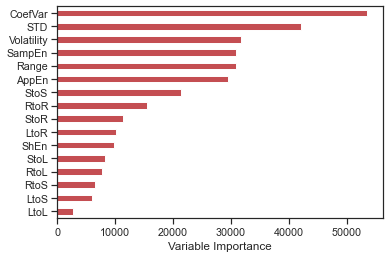

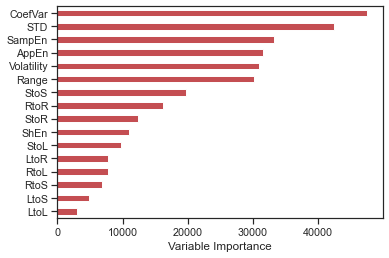

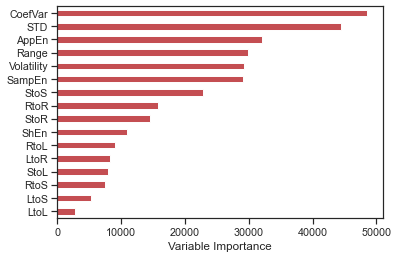

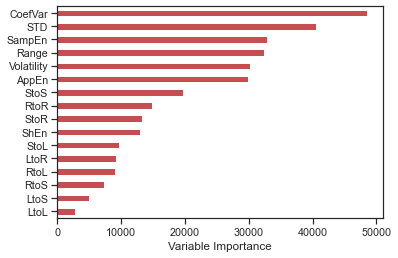

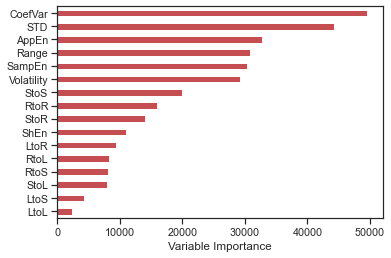

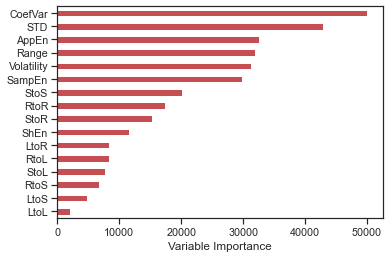

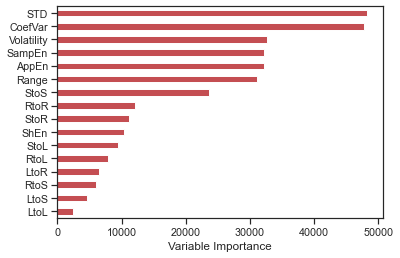

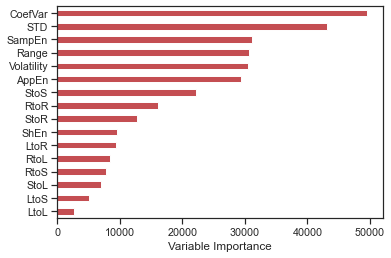

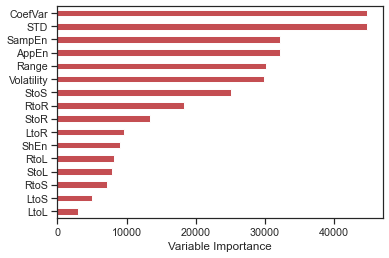

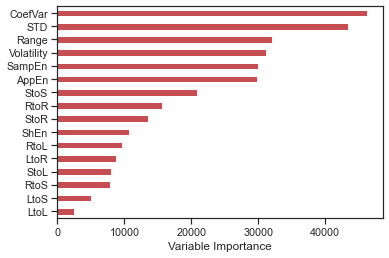

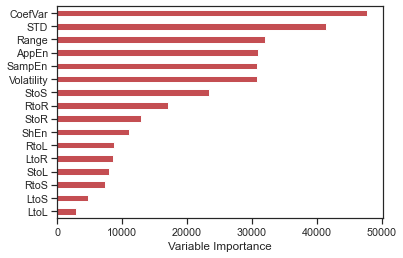

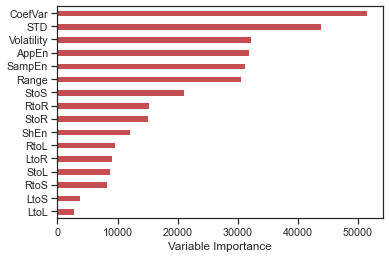

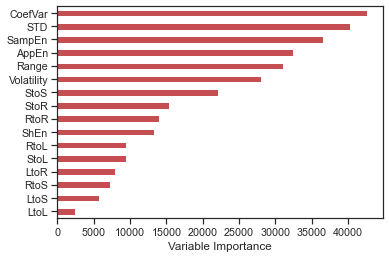

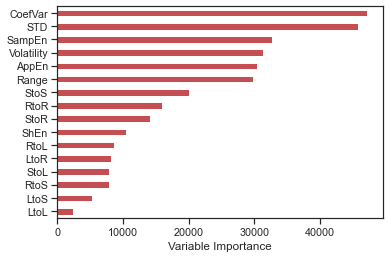

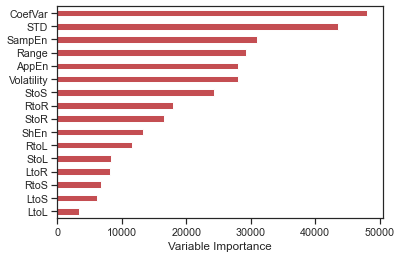

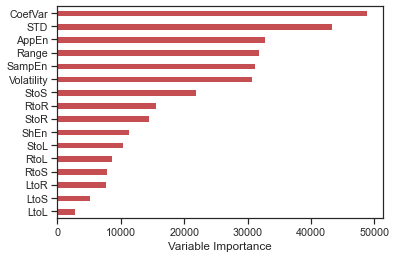

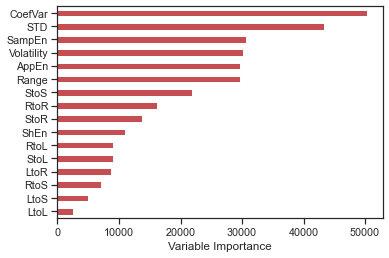

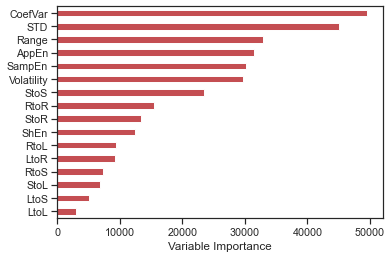

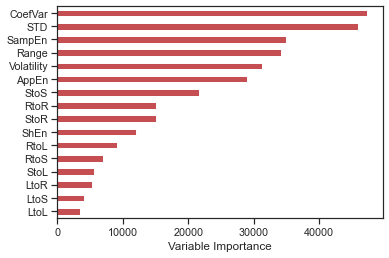

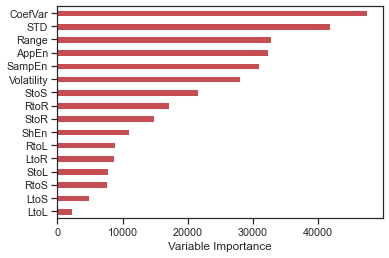

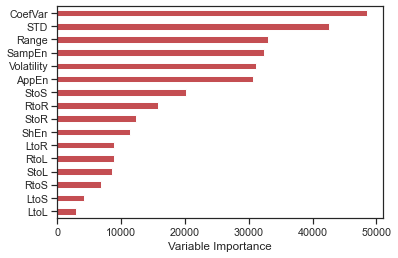

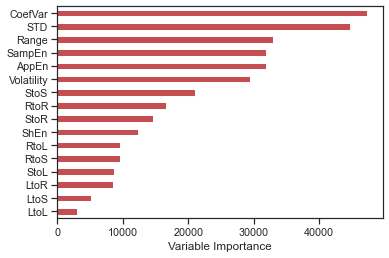

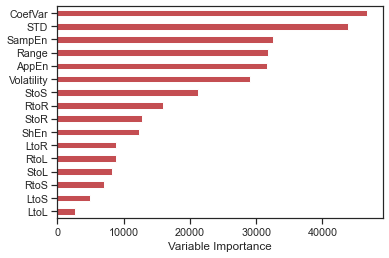

In [37]:
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
import lightgbm

#Implementing cross validation 
kf = KFold(n_splits=23, random_state=1, shuffle=True)


from time import time
import timeit #imports timeit module
start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = [];
Truth = [];
Output = [];
n_estimators_list = []
max_depth_list = []

x_values = ['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS',
       'LtoR', 'LtoL', 'STD', 'CoefVar', 'Range', 'Volatility', 'ShEn',
       'AppEn', 'SampEn']
y_values = ['Rhythm']
df = features_maindf

for idx, subject in enumerate(good_list):
    
    train_index = ~df['Subject'].str.contains(subject)
    test_index = df['Subject'].str.contains(subject)
    X_train , X_test = df.loc[train_index,x_values], df.loc[test_index,x_values]
    y_train , y_test = df.loc[train_index,y_values].values.ravel(), df.loc[test_index,y_values]

    temp_model = model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],eval_metric='logloss')    
    param_distributions = {'n_estimators': randint(105, 110),
                           'max_depth': randint(7,10)}

    search = RandomizedSearchCV(estimator=temp_model, param_distributions=param_distributions, random_state=0)
    search.fit(X_train, y_train)

    n_estimators_list.append(search.best_params_['n_estimators'])
    max_depth_list.append(search.best_params_['max_depth'])

#     model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
#           eval_metric='logloss')
    model = lightgbm.LGBMClassifier(learning_rate=0.09,max_depth=search.best_params_['max_depth'],n_estimators=search.best_params_['n_estimators'], random_state=42)
    
    # Create the LightGBM data containers
    model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
          eval_metric='logloss')

    pred_values = model.predict(X_test)
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list  
    
    #print(model.feature_importances_)
    Importance = pd.DataFrame({'Importance':(model.feature_importances_*100)}, 
                          index = (X_train.columns))
    Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r')
    plt.xlabel('Variable Importance')
    plt.gca().legend_ = None
    #plt.savefig('plot1.png')


elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

In [34]:
print(confusion_matrix(Truth, Output))
print(classification_report(Truth, Output))
print(acc_score)
print(elapsed)
print(n_estimators_list)
print(max_depth_list)
#old confusion matrix
#[23104  1639]
#  [ 1720 18505]]
# ---Run time is 155.16974349999873 seconds ---

# Accuracy of each fold: 
#  [0.9164759725400458, 0.9537525354969574, 0.9962216624685138, 0.9268585131894485, 0.9979101358411703, 0.959026369168357, 0.7678654834189631, 0.998638529611981, 0.9392570281124498, 0.9718853362734289, 0.9823049001814882, 0.990667623833453, 0.8285714285714286, 0.9560509554140127, 0.6040799333888426, 0.9880372175454143, 0.9897189856065799, 0.9873052510098096, 0.7514792899408284, 0.959868059373282, 0.9957228400342173, 0.997489014438167, 0.9974630021141649]

# Avg accuracy : 
# 0.9328978290249132

# Std of accuracy : 
# 0.09852275116924226

[[23104  1639]
 [ 1720 18505]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     24743
           1       0.92      0.91      0.92     20225

    accuracy                           0.93     44968
   macro avg       0.92      0.92      0.92     44968
weighted avg       0.93      0.93      0.93     44968

[0.9164759725400458, 0.9537525354969574, 0.9962216624685138, 0.9268585131894485, 0.9979101358411703, 0.959026369168357, 0.7678654834189631, 0.998638529611981, 0.9392570281124498, 0.9718853362734289, 0.9823049001814882, 0.990667623833453, 0.8285714285714286, 0.9560509554140127, 0.6040799333888426, 0.9880372175454143, 0.9897189856065799, 0.9873052510098096, 0.7514792899408284, 0.959868059373282, 0.9957228400342173, 0.997489014438167, 0.9974630021141649]
199.88120800000615
[106, 105, 106, 106, 106, 107, 106, 105, 107, 105, 106, 109, 106, 106, 108, 108, 106, 108, 107, 106, 106, 109, 106]
[9, 9, 9, 9, 9, 8, 9, 9, 8, 9, 9, 8, 8, 9, 8, 8, 9,

In [35]:
# ---Run time is 199.88120800000615 seconds ---

# Accuracy of each fold: 
#  [0.9164759725400458, 0.9537525354969574, 0.9962216624685138, 0.9268585131894485, 0.9979101358411703, 0.959026369168357, 0.7678654834189631, 0.998638529611981, 0.9392570281124498, 0.9718853362734289, 0.9823049001814882, 0.990667623833453, 0.8285714285714286, 0.9560509554140127, 0.6040799333888426, 0.9880372175454143, 0.9897189856065799, 0.9873052510098096, 0.7514792899408284, 0.959868059373282, 0.9957228400342173, 0.997489014438167, 0.9974630021141649]

# Avg accuracy : 
# 0.9328978290249132

# Std of accuracy : 
# 0.09852275116924226
#[[23104  1639]
# [ 1720 18505]]

In [28]:
temp_list = []
temp_idx = []
for acc in acc_score:
    if acc >= 0.97:
        temp_list.append(acc)
        temp_idx.append(acc_score.index(acc))
for idx in temp_idx:
    print(n_estimators_list[idx])
    print(max_depth_list[idx])

106
9
106
9
105
9
105
9
106
9
109
8
108
8
106
9
108
8
106
9
109
8
106
9


In [33]:
import statistics

print(statistics.mode(n_estimators_list))
print(statistics.mode(max_depth_list))

106
9


C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618356	valid_0's binary_logloss: 0.571408
[2]	training's binary_logloss: 0.55755	valid_0's binary_logloss: 0.521635
[3]	training's binary_logloss: 0.505937	valid_0's binary_logloss: 0.479841
[4]	training's binary_logloss: 0.461077	valid_0's binary_logloss: 0.444658
[5]	training's binary_logloss: 0.422435	valid_0's binary_logloss: 0.413974
[6]	training's binary_logloss: 0.38893	valid_0's binary_logloss: 0.388499
[7]	training's binary_logloss: 0.359628	valid_0's binary_logloss: 0.365992
[8]	training's binary_logloss: 0.333592	valid_0's binary_logloss: 0.347248
[9]	training's binary_logloss: 0.310354	valid_0's binary_logloss: 0.331608
[1]	training's binary_logloss: 0.618031	valid_0's binary_logloss: 0.587241
[2]	training's binary_logloss: 0.557826	valid_0's binary_logloss: 0.529984
[3]	training's binary_logloss: 0.506602	valid_0's binary_logloss: 0.481112
[4]	training's binary_logloss: 0.462222	valid_0's binary_logloss: 0.439001
[5]	training's binary_loglo

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618971	valid_0's binary_logloss: 0.555954
[2]	training's binary_logloss: 0.558959	valid_0's binary_logloss: 0.494263
[3]	training's binary_logloss: 0.507991	valid_0's binary_logloss: 0.440917
[4]	training's binary_logloss: 0.464155	valid_0's binary_logloss: 0.395268
[5]	training's binary_logloss: 0.425893	valid_0's binary_logloss: 0.355017
[6]	training's binary_logloss: 0.392805	valid_0's binary_logloss: 0.319867
[7]	training's binary_logloss: 0.36368	valid_0's binary_logloss: 0.28888
[8]	training's binary_logloss: 0.338182	valid_0's binary_logloss: 0.261857
[9]	training's binary_logloss: 0.315523	valid_0's binary_logloss: 0.237544
[1]	training's binary_logloss: 0.617806	valid_0's binary_logloss: 0.582015
[2]	training's binary_logloss: 0.55692	valid_0's binary_logloss: 0.538577
[3]	training's binary_logloss: 0.505198	valid_0's binary_logloss: 0.500806
[4]	training's binary_logloss: 0.461029	valid_0's binary_logloss: 0.468758
[5]	training's binary_loglos

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.61445	valid_0's binary_logloss: 0.645708
[2]	training's binary_logloss: 0.55478	valid_0's binary_logloss: 0.572508
[3]	training's binary_logloss: 0.504202	valid_0's binary_logloss: 0.510262
[4]	training's binary_logloss: 0.460493	valid_0's binary_logloss: 0.45734
[5]	training's binary_logloss: 0.422878	valid_0's binary_logloss: 0.411441
[6]	training's binary_logloss: 0.389921	valid_0's binary_logloss: 0.371323
[7]	training's binary_logloss: 0.361302	valid_0's binary_logloss: 0.336232
[8]	training's binary_logloss: 0.335705	valid_0's binary_logloss: 0.305397
[9]	training's binary_logloss: 0.313508	valid_0's binary_logloss: 0.278328
[1]	training's binary_logloss: 0.619273	valid_0's binary_logloss: 0.586657
[2]	training's binary_logloss: 0.558414	valid_0's binary_logloss: 0.529604
[3]	training's binary_logloss: 0.506881	valid_0's binary_logloss: 0.481345
[4]	training's binary_logloss: 0.462765	valid_0's binary_logloss: 0.439885
[5]	training's binary_loglos

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.611158	valid_0's binary_logloss: 0.704557
[2]	training's binary_logloss: 0.550056	valid_0's binary_logloss: 0.654679
[3]	training's binary_logloss: 0.498458	valid_0's binary_logloss: 0.611978
[4]	training's binary_logloss: 0.454251	valid_0's binary_logloss: 0.578231
[5]	training's binary_logloss: 0.415863	valid_0's binary_logloss: 0.547121
[6]	training's binary_logloss: 0.382357	valid_0's binary_logloss: 0.522196
[7]	training's binary_logloss: 0.353078	valid_0's binary_logloss: 0.500826
[8]	training's binary_logloss: 0.326855	valid_0's binary_logloss: 0.48349
[9]	training's binary_logloss: 0.303885	valid_0's binary_logloss: 0.470271
[1]	training's binary_logloss: 0.618809	valid_0's binary_logloss: 0.552484
[2]	training's binary_logloss: 0.558743	valid_0's binary_logloss: 0.490586
[3]	training's binary_logloss: 0.507786	valid_0's binary_logloss: 0.437714
[4]	training's binary_logloss: 0.463908	valid_0's binary_logloss: 0.392085
[5]	training's binary_logl

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.61331	valid_0's binary_logloss: 0.666351
[2]	training's binary_logloss: 0.553059	valid_0's binary_logloss: 0.602082
[3]	training's binary_logloss: 0.502024	valid_0's binary_logloss: 0.547852
[4]	training's binary_logloss: 0.458035	valid_0's binary_logloss: 0.502356
[5]	training's binary_logloss: 0.419923	valid_0's binary_logloss: 0.462547
[6]	training's binary_logloss: 0.386748	valid_0's binary_logloss: 0.428637
[7]	training's binary_logloss: 0.357564	valid_0's binary_logloss: 0.398481
[8]	training's binary_logloss: 0.331938	valid_0's binary_logloss: 0.372235
[9]	training's binary_logloss: 0.309253	valid_0's binary_logloss: 0.349561
[1]	training's binary_logloss: 0.618701	valid_0's binary_logloss: 0.567326
[2]	training's binary_logloss: 0.558192	valid_0's binary_logloss: 0.511745
[3]	training's binary_logloss: 0.507049	valid_0's binary_logloss: 0.463945
[4]	training's binary_logloss: 0.46307	valid_0's binary_logloss: 0.422857
[5]	training's binary_loglo

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.60964	valid_0's binary_logloss: 0.742147
[2]	training's binary_logloss: 0.550117	valid_0's binary_logloss: 0.656346
[3]	training's binary_logloss: 0.49939	valid_0's binary_logloss: 0.58486
[4]	training's binary_logloss: 0.455975	valid_0's binary_logloss: 0.524415
[5]	training's binary_logloss: 0.41859	valid_0's binary_logloss: 0.472895
[6]	training's binary_logloss: 0.3859	valid_0's binary_logloss: 0.428285
[7]	training's binary_logloss: 0.357391	valid_0's binary_logloss: 0.389516
[8]	training's binary_logloss: 0.332302	valid_0's binary_logloss: 0.35575
[9]	training's binary_logloss: 0.310251	valid_0's binary_logloss: 0.326065


C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618523	valid_0's binary_logloss: 0.554149
[2]	training's binary_logloss: 0.558437	valid_0's binary_logloss: 0.493825
[3]	training's binary_logloss: 0.507192	valid_0's binary_logloss: 0.442632
[4]	training's binary_logloss: 0.463226	valid_0's binary_logloss: 0.39824
[5]	training's binary_logloss: 0.425038	valid_0's binary_logloss: 0.359722
[6]	training's binary_logloss: 0.391729	valid_0's binary_logloss: 0.325808
[7]	training's binary_logloss: 0.362647	valid_0's binary_logloss: 0.29596
[8]	training's binary_logloss: 0.337163	valid_0's binary_logloss: 0.269642
[9]	training's binary_logloss: 0.314487	valid_0's binary_logloss: 0.24625
[1]	training's binary_logloss: 0.614536	valid_0's binary_logloss: 0.651825
[2]	training's binary_logloss: 0.552764	valid_0's binary_logloss: 0.614605
[3]	training's binary_logloss: 0.500443	valid_0's binary_logloss: 0.584559
[4]	training's binary_logloss: 0.455375	valid_0's binary_logloss: 0.560447
[5]	training's binary_loglos

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.611531	valid_0's binary_logloss: 0.74872
[2]	training's binary_logloss: 0.551738	valid_0's binary_logloss: 0.67037
[3]	training's binary_logloss: 0.500968	valid_0's binary_logloss: 0.606065
[4]	training's binary_logloss: 0.457572	valid_0's binary_logloss: 0.550493
[5]	training's binary_logloss: 0.419929	valid_0's binary_logloss: 0.503941
[6]	training's binary_logloss: 0.387169	valid_0's binary_logloss: 0.461984
[7]	training's binary_logloss: 0.358532	valid_0's binary_logloss: 0.424769
[8]	training's binary_logloss: 0.333525	valid_0's binary_logloss: 0.395652
[9]	training's binary_logloss: 0.311111	valid_0's binary_logloss: 0.368403
[1]	training's binary_logloss: 0.60551	valid_0's binary_logloss: 0.842989
[2]	training's binary_logloss: 0.543833	valid_0's binary_logloss: 0.833911
[3]	training's binary_logloss: 0.491807	valid_0's binary_logloss: 0.829444
[4]	training's binary_logloss: 0.44722	valid_0's binary_logloss: 0.824226
[5]	training's binary_logloss

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.613166	valid_0's binary_logloss: 0.66977
[2]	training's binary_logloss: 0.553174	valid_0's binary_logloss: 0.598476
[3]	training's binary_logloss: 0.502196	valid_0's binary_logloss: 0.539332
[4]	training's binary_logloss: 0.458775	valid_0's binary_logloss: 0.488621
[5]	training's binary_logloss: 0.421154	valid_0's binary_logloss: 0.443989
[6]	training's binary_logloss: 0.388289	valid_0's binary_logloss: 0.405673
[7]	training's binary_logloss: 0.359409	valid_0's binary_logloss: 0.372492
[8]	training's binary_logloss: 0.334106	valid_0's binary_logloss: 0.342503
[9]	training's binary_logloss: 0.311806	valid_0's binary_logloss: 0.316594
[1]	training's binary_logloss: 0.617748	valid_0's binary_logloss: 0.57054
[2]	training's binary_logloss: 0.557663	valid_0's binary_logloss: 0.508328
[3]	training's binary_logloss: 0.506382	valid_0's binary_logloss: 0.455331
[4]	training's binary_logloss: 0.462491	valid_0's binary_logloss: 0.409614
[5]	training's binary_loglo

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.613431	valid_0's binary_logloss: 0.67455
[2]	training's binary_logloss: 0.553649	valid_0's binary_logloss: 0.598438
[3]	training's binary_logloss: 0.502975	valid_0's binary_logloss: 0.53437
[4]	training's binary_logloss: 0.459241	valid_0's binary_logloss: 0.478847
[5]	training's binary_logloss: 0.421462	valid_0's binary_logloss: 0.430853
[6]	training's binary_logloss: 0.388726	valid_0's binary_logloss: 0.389316
[7]	training's binary_logloss: 0.360059	valid_0's binary_logloss: 0.352857
[8]	training's binary_logloss: 0.33484	valid_0's binary_logloss: 0.320654
[9]	training's binary_logloss: 0.31228	valid_0's binary_logloss: 0.292499
[1]	training's binary_logloss: 0.61584	valid_0's binary_logloss: 0.6302
[2]	training's binary_logloss: 0.553695	valid_0's binary_logloss: 0.608373
[3]	training's binary_logloss: 0.500519	valid_0's binary_logloss: 0.588634
[4]	training's binary_logloss: 0.455042	valid_0's binary_logloss: 0.573967
[5]	training's binary_logloss: 0

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


[1]	training's binary_logloss: 0.617564	valid_0's binary_logloss: 0.587893
[2]	training's binary_logloss: 0.557454	valid_0's binary_logloss: 0.530035
[3]	training's binary_logloss: 0.50609	valid_0's binary_logloss: 0.479713
[4]	training's binary_logloss: 0.462218	valid_0's binary_logloss: 0.437662
[5]	training's binary_logloss: 0.42431	valid_0's binary_logloss: 0.400817
[6]	training's binary_logloss: 0.390978	valid_0's binary_logloss: 0.367998
[7]	training's binary_logloss: 0.36186	valid_0's binary_logloss: 0.338306
[8]	training's binary_logloss: 0.336257	valid_0's binary_logloss: 0.312741
[9]	training's binary_logloss: 0.313546	valid_0's binary_logloss: 0.291234
[1]	training's binary_logloss: 0.612482	valid_0's binary_logloss: 0.681816
[2]	training's binary_logloss: 0.552984	valid_0's binary_logloss: 0.604967
[3]	training's binary_logloss: 0.502117	valid_0's binary_logloss: 0.539799
[4]	training's binary_logloss: 0.458769	valid_0's binary_logloss: 0.484569
[5]	training's binary_loglos

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618483	valid_0's binary_logloss: 0.559981
[2]	training's binary_logloss: 0.55826	valid_0's binary_logloss: 0.49893
[3]	training's binary_logloss: 0.507178	valid_0's binary_logloss: 0.446448
[4]	training's binary_logloss: 0.4634	valid_0's binary_logloss: 0.401518
[5]	training's binary_logloss: 0.42534	valid_0's binary_logloss: 0.361863
[6]	training's binary_logloss: 0.392389	valid_0's binary_logloss: 0.327432
[7]	training's binary_logloss: 0.363407	valid_0's binary_logloss: 0.297145
[8]	training's binary_logloss: 0.337844	valid_0's binary_logloss: 0.269982
[9]	training's binary_logloss: 0.315454	valid_0's binary_logloss: 0.24619
[1]	training's binary_logloss: 0.612732	valid_0's binary_logloss: 0.675837
[2]	training's binary_logloss: 0.553241	valid_0's binary_logloss: 0.600325
[3]	training's binary_logloss: 0.502439	valid_0's binary_logloss: 0.536319
[4]	training's binary_logloss: 0.458981	valid_0's binary_logloss: 0.482263
[5]	training's binary_logloss: 

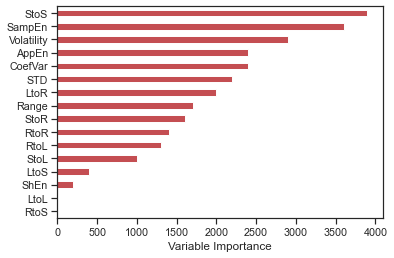

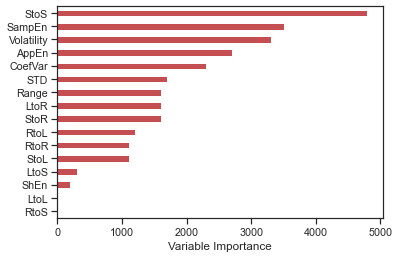

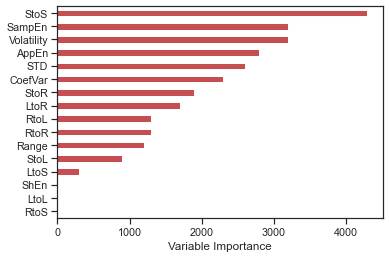

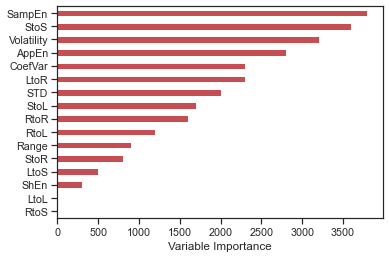

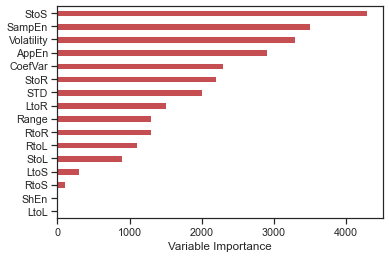

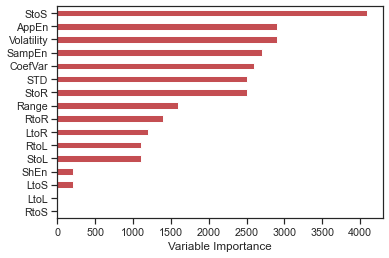

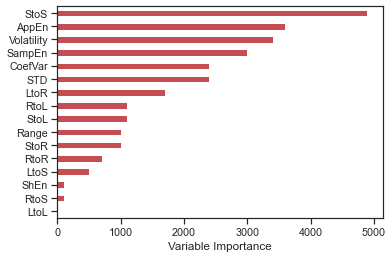

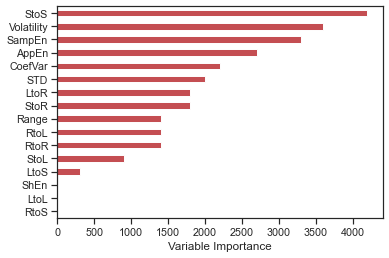

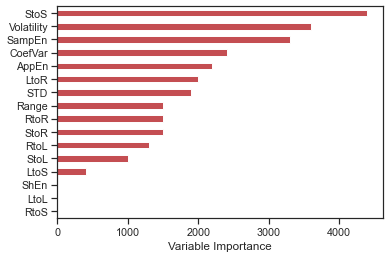

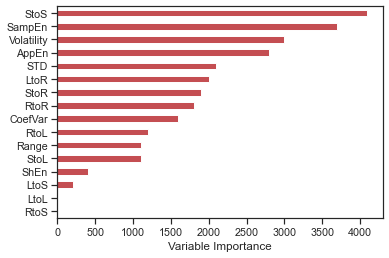

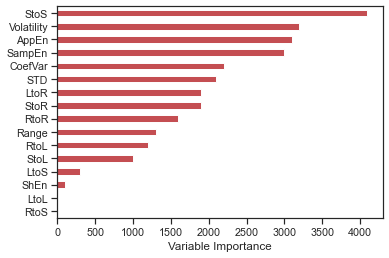

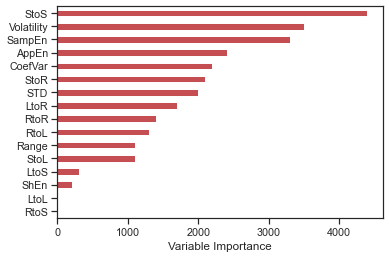

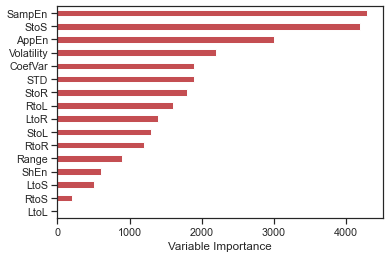

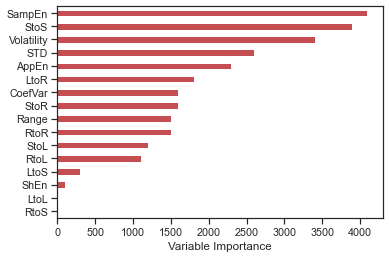

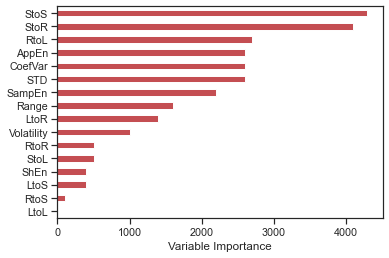

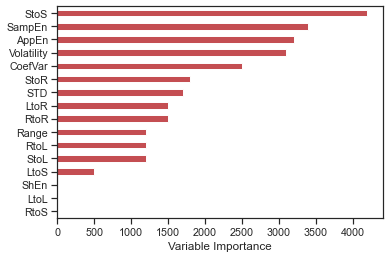

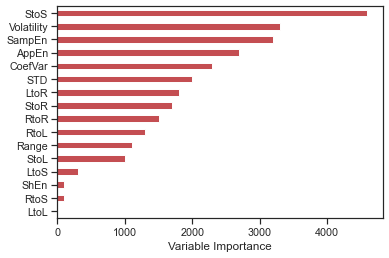

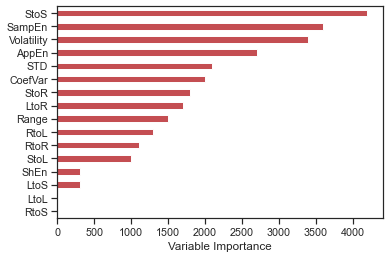

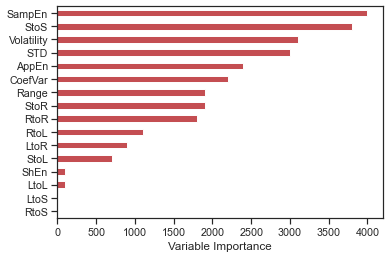

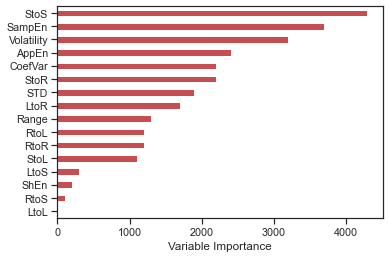

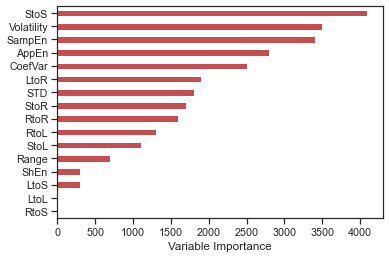

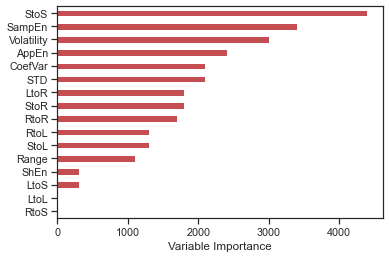

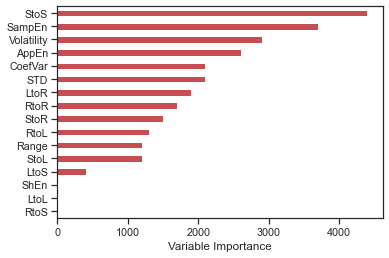

In [38]:
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
import lightgbm

#Implementing cross validation 
kf = KFold(n_splits=23, random_state=1, shuffle=True)


from time import time
import timeit #imports timeit module
start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = [];
Truth = [];
Output = [];
n_estimators_list = []
max_depth_list = []

x_values = ['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS',
       'LtoR', 'LtoL', 'STD', 'CoefVar', 'Range', 'Volatility', 'ShEn',
       'AppEn', 'SampEn']
y_values = ['Rhythm']
df = features_maindf

for idx, subject in enumerate(good_list):
    
    train_index = ~df['Subject'].str.contains(subject)
    test_index = df['Subject'].str.contains(subject)
    X_train , X_test = df.loc[train_index,x_values], df.loc[test_index,x_values]
    y_train , y_test = df.loc[train_index,y_values].values.ravel(), df.loc[test_index,y_values]

#     temp_model = model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],eval_metric='logloss')    
#     param_distributions = {'n_estimators': randint(105, 110),
#                            'max_depth': randint(7,10)}

#     search = RandomizedSearchCV(estimator=temp_model, param_distributions=param_distributions, random_state=0)
#     search.fit(X_train, y_train)

#     n_estimators_list.append(search.best_params_['n_estimators'])
#     max_depth_list.append(search.best_params_['max_depth'])

#     model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
#           eval_metric='logloss')
    model = lightgbm.LGBMClassifier(learning_rate=0.09,max_depth=106,n_estimators=9, random_state=42)
    
    # Create the LightGBM data containers
    model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
          eval_metric='logloss')

    pred_values = model.predict(X_test)
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list  
    
    #print(model.feature_importances_)
    Importance = pd.DataFrame({'Importance':(model.feature_importances_*100)}, 
                          index = (X_train.columns))
    Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r')
    plt.xlabel('Variable Importance')
    plt.gca().legend_ = None
    #plt.savefig('plot1.png')


elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

In [40]:
print(confusion_matrix(Truth, Output))
print(classification_report(Truth, Output))
print(acc_score)
print(elapsed)
# [[22875  1868]
#  [ 1984 18241]]
# Accuracy of each fold: 
#  [0.9096109839816934, 0.9533468559837728, 0.9955919395465995, 0.8974820143884892, 0.9947753396029259, 0.9484787018255578, 0.832788416627744, 0.9965963240299524, 0.9362449799196787, 0.964167585446527, 0.9818511796733213, 0.9899497487437185, 0.7836734693877551, 0.9178343949044586, 0.4995836802664446, 0.9787328311918476, 0.9876627827278959, 0.9924985574148875, 0.7176669484361792, 0.9741616272677295, 0.9957228400342173, 0.9912115505335845, 0.9877378435517971]

# Avg accuracy : 
# 0.9229291563255121

# Std of accuracy : 
# 0.11533339006243011

[[22875  1868]
 [ 1984 18241]]
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     24743
           1       0.91      0.90      0.90     20225

    accuracy                           0.91     44968
   macro avg       0.91      0.91      0.91     44968
weighted avg       0.91      0.91      0.91     44968

[0.9096109839816934, 0.9533468559837728, 0.9955919395465995, 0.8974820143884892, 0.9947753396029259, 0.9484787018255578, 0.832788416627744, 0.9965963240299524, 0.9362449799196787, 0.964167585446527, 0.9818511796733213, 0.9899497487437185, 0.7836734693877551, 0.9178343949044586, 0.4995836802664446, 0.9787328311918476, 0.9876627827278959, 0.9924985574148875, 0.7176669484361792, 0.9741616272677295, 0.9957228400342173, 0.9912115505335845, 0.9877378435517971]
3.0463111999997636
